In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/CG4002/"IMU_combined_data"
!ls

Mounted at /content/drive
/content/drive/My Drive/CG4002/IMU_combined_data
combined_data_as.csv  combined_data_jn.csv  combined_data_zh.csv  scaler.save
combined_data_iz.csv  combined_data_vi.csv  model


In [ ]:
import glob
import math
import numpy as np
import pandas as pd
import keras
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
import joblib

In [ ]:
labels = ["grenade", "idle", "logout", "reload", "shield"]

In [ ]:
df = pd.read_csv("combined_data_jn.csv", index_col=0)
df = pd.concat([df, pd.read_csv("combined_data_as.csv", index_col=0)])
df = pd.concat([df, pd.read_csv("combined_data_iz.csv", index_col=0)])
df = pd.concat([df, pd.read_csv("combined_data_zh.csv", index_col=0)])
df = pd.concat([df, pd.read_csv("combined_data_vi.csv", index_col=0)])
df.reset_index(drop=True, inplace=True)
df

,ax,ay,az,gx,gy,gz,action
0,-8.58,3.53,-11.75,225.28,19.38,-193.08,grenade
1,-10.43,5.23,-16.40,151.31,-4.83,-73.35,grenade
2,-8.17,5.50,-15.60,-36.02,-57.72,54.55,grenade
3,-7.55,4.00,-15.46,-207.93,50.73,166.27,grenade
4,-5.69,-2.67,-12.69,155.33,14.48,242.60,grenade
...,...,...,...,...,...,...,...
37760,11.42,-14.78,-3.97,90.40,-127.95,226.09,shield
37761,11.24,-13.51,-3.90,67.78,-158.71,162.90,shield
37762,11.53,-11.28,-3.42,73.29,-152.18,124.76,shield
37763,9.92,-8.63,-3.55,46.52,-132.77,76.11,shield


In [ ]:
samples_per_action = 35
# One column for each sample in frame
expanded_labels = []
for i in range(samples_per_action):
  expanded_labels.extend(['ax' + str(i), 'ay' + str(i), 'az' + str(i), 'gx' + str(i), 'gy' + str(i), 'gz' + str(i)])

expanded_labels.append('action')

In [ ]:
frame_data = {}
count = 0
index = 0
for label in labels:
  df_label = df[df['action'] == label]
  frame = []
  count = 0
  for i, row in df_label.iterrows():
    frame.extend(list(row)[:-1])
    count += 1
    if count == samples_per_action:
      frame_data[index] = frame + [label]
      count = 0
      index += 1
      frame = []

In [ ]:
df_frame = pd.DataFrame.from_dict(frame_data, orient='index', columns=expanded_labels)
df_frame

,ax0,ay0,az0,gx0,gy0,gz0,ax1,ay1,az1,gx1,...,gx33,gy33,gz33,ax34,ay34,az34,gx34,gy34,gz34,action
0,-8.58,3.53,-11.75,225.28,19.38,-193.08,-10.43,5.23,-16.40,151.31,...,-1.00,10.88,-11.84,0.73,-10.06,-1.28,-18.23,15.51,-5.40,grenade
1,-8.58,3.53,-11.75,225.28,19.38,-193.08,-10.43,5.23,-16.40,151.31,...,-1.00,10.88,-11.84,0.73,-10.06,-1.28,-18.23,15.51,-5.40,grenade
2,11.68,-1.60,13.46,311.27,80.71,187.02,6.43,-1.33,11.63,-278.20,...,14.97,-69.00,147.70,10.60,-11.46,-1.20,-15.58,103.58,47.00,grenade
3,6.78,4.27,16.97,-159.58,-86.03,-223.11,7.44,3.31,12.08,-185.85,...,-81.24,-281.83,244.37,13.10,-17.01,2.79,-45.70,15.93,264.82,grenade
4,7.31,3.62,14.13,-220.10,-68.70,-260.44,6.63,3.27,12.62,-226.82,...,134.18,259.66,261.40,13.81,-22.35,-11.26,91.94,235.58,272.58,grenade
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1074,14.42,-13.04,-11.14,-187.45,107.12,-244.75,12.52,-13.73,-11.78,-200.57,...,1.41,-169.64,179.56,10.93,-11.87,-2.95,22.60,-165.20,133.20,shield
1075,14.41,-12.89,-11.01,-200.66,20.82,283.85,13.91,-11.36,-10.75,-225.39,...,27.92,-78.16,37.29,6.48,-7.43,-2.96,29.95,-48.34,37.38,shield
1076,14.41,-12.89,-11.01,-200.66,20.82,283.85,13.91,-11.36,-10.75,-225.39,...,27.92,-78.16,37.29,6.48,-7.43,-2.96,29.95,-48.34,37.38,shield
1077,14.70,-14.78,-7.94,-153.17,132.25,-249.48,14.14,-15.44,-9.00,-174.14,...,14.42,-34.59,75.44,6.59,-8.10,-1.48,21.42,-46.87,34.16,shield


In [ ]:
df_frame.drop(df_frame.columns[174:210], axis=1, inplace=True)
df_frame

,ax0,ay0,az0,gx0,gy0,gz0,ax1,ay1,az1,gx1,...,gx27,gy27,gz27,ax28,ay28,az28,gx28,gy28,gz28,action
0,-8.58,3.53,-11.75,225.28,19.38,-193.08,-10.43,5.23,-16.40,151.31,...,-26.26,-33.31,37.05,6.03,-9.37,-0.60,22.84,-76.71,-20.29,grenade
1,-8.58,3.53,-11.75,225.28,19.38,-193.08,-10.43,5.23,-16.40,151.31,...,-26.26,-33.31,37.05,6.03,-9.37,-0.60,22.84,-76.71,-20.29,grenade
2,11.68,-1.60,13.46,311.27,80.71,187.02,6.43,-1.33,11.63,-278.20,...,271.61,290.22,318.49,15.79,-19.28,-1.15,-115.18,155.33,269.85,grenade
3,6.78,4.27,16.97,-159.58,-86.03,-223.11,7.44,3.31,12.08,-185.85,...,-167.90,-158.33,-49.82,1.08,-2.50,4.85,-136.31,-153.02,2.88,grenade
4,7.31,3.62,14.13,-220.10,-68.70,-260.44,6.63,3.27,12.62,-226.82,...,-145.36,-179.88,-64.70,-0.09,-4.54,3.38,-172.54,-204.04,13.64,grenade
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1074,14.42,-13.04,-11.14,-187.45,107.12,-244.75,12.52,-13.73,-11.78,-200.57,...,-31.66,-132.39,284.94,11.42,-11.20,-1.48,18.35,-85.25,304.26,shield
1075,14.41,-12.89,-11.01,-200.66,20.82,283.85,13.91,-11.36,-10.75,-225.39,...,101.99,-71.21,266.39,12.87,-13.12,-5.58,89.13,-96.13,221.95,shield
1076,14.41,-12.89,-11.01,-200.66,20.82,283.85,13.91,-11.36,-10.75,-225.39,...,101.99,-71.21,266.39,12.87,-13.12,-5.58,89.13,-96.13,221.95,shield
1077,14.70,-14.78,-7.94,-153.17,132.25,-249.48,14.14,-15.44,-9.00,-174.14,...,48.58,-171.23,266.79,11.54,-12.70,-6.24,77.82,-98.67,261.32,shield


In [ ]:
# sampling = []
# add = 0
# for i in range(300):
#   if i and i % 6 == 0:
#     add = 1 - add
#   if add:
#     sampling.append(i)

# df_frame.drop(df_frame.columns[sampling], axis=1, inplace=True)
# df_frame

In [ ]:
df_frame['action'].value_counts()['shield']

207

In [ ]:
for elem in list(df_frame.iloc[0]):
  print(elem, end=',')

-8.58,3.53,-11.75,225.28,19.38,-193.08,-10.43,5.23,-16.4,151.31,-4.83,-73.35,-8.17,5.5,-15.6,-36.02,-57.72,54.55,-7.55,4.0,-15.46,-207.93,50.73,166.27,-5.69,-2.67,-12.69,155.33,14.48,242.6,-2.91,-16.96,-3.82,155.33,-22.34,250.06,-2.02,-13.58,-4.84,160.25,66.88,211.77,-1.6,-18.36,5.3,312.03,239.42,186.73,2.51,-9.17,21.19,-161.26,-242.8,252.85,0.59,1.01,10.37,-48.11,-275.36,-63.0,-0.6,-0.06,8.54,50.05,-73.61,-163.81,-6.25,4.42,3.82,15.03,144.92,-2.13,-3.42,3.62,5.72,-157.26,-107.53,21.24,1.87,-3.11,5.97,-143.18,-44.46,69.53,1.31,1.69,4.34,-36.42,3.47,-17.67,0.91,-3.5,3.25,-133.18,-62.09,-16.03,0.26,-2.43,2.87,-56.49,-15.48,-52.35,-1.06,-6.05,3.2,-214.26,-95.0,-8.74,-0.05,-6.95,3.4,-165.66,-143.21,24.27,0.79,-11.58,4.13,-315.65,-177.27,100.73,3.18,-14.37,4.87,-273.01,326.04,164.01,7.87,-22.02,2.95,291.81,311.63,216.18,7.65,-21.03,2.53,-131.25,238.51,201.11,13.84,-24.36,-2.53,-79.07,155.33,194.58,18.78,-17.85,-3.77,65.2,-246.6,180.2,12.94,-12.17,-3.75,13.3,-19.73,112.05,7.68,-11.39,-1.04,-

Start of move Thresholding

In [ ]:
# label='logout'
# field_dict = {'yaw': 0, 'pitch': 1, 'roll': 2}
# df_class = df_frame.iloc[df_frame[df_frame['action'] == label].iloc[0].name:df_frame[df_frame['action'] == label].iloc[0].name + df_frame['action'].value_counts()[label]]
# df_class.reset_index(drop=True, inplace=True)
# df_class.drop(columns=['action'], inplace=True)
# for i in range(30, 40):
#   action = df_class.iloc[i]

#   plt.plot(np.arange(0, samples_per_action), action[field_dict['yaw']::3], c = 'blue')
#   plt.plot(np.arange(0, samples_per_action), action[field_dict['pitch']::3], c = 'red')
#   plt.plot(np.arange(0, samples_per_action), action[field_dict['roll']::3], c = 'green')

In [ ]:
# frame_size = 5
# threshold = 5
# for label in labels:
#   df_class = df_frame.iloc[df_frame[df_frame['action'] == label].iloc[0].name:df_frame[df_frame['action'] == label].iloc[0].name + df_frame['action'].value_counts()[label]]
#   df_class.reset_index(drop=True, inplace=True)
#   df_class.drop(columns=['action'], inplace=True)
#   for i in range(df_frame['action'].value_counts()[label]):
#     action = df_class.iloc[i]

#     start = 0
#     end = 59

#     # Find start
#     yaw_prev = None
#     pitch_prev = None
#     roll_avg = None
#     for j in range(56):
#       window = action[j*3:j*3 + frame_size*3]
#       yaw_avg = sum(window[0::3])/frame_size
#       pitch_avg = sum(window[1::3])/frame_size
#       roll_avg = sum(window[2::3])/frame_size
#       if yaw_prev != None:
#         avg_check = [abs(yaw_avg - yaw_prev) > threshold, abs(pitch_avg - pitch_prev) > threshold, abs(roll_avg - roll_prev) > threshold]
#         if sum(avg_check) >= 1:
#           start = j
#           break
#       yaw_prev = yaw_avg
#       pitch_prev = pitch_avg
#       roll_prev = roll_avg

#     # Find end
#     yaw_prev = None
#     pitch_prev = None
#     roll_avg = None
#     for j in reversed(range(59)):
#       window = action[j*3:j*3 + frame_size*3]
#       yaw_avg = sum(window[0::3])/frame_size
#       pitch_avg = sum(window[1::3])/frame_size
#       roll_avg = sum(window[2::3])/frame_size
#       if yaw_prev != None:
#         avg_check = [abs(yaw_avg - yaw_prev) > threshold, abs(pitch_avg - pitch_prev) > threshold, abs(roll_avg - roll_prev) > threshold]
#         if sum(avg_check) >= 1:
#           end = min(j + frame_size, 59)
#           break
#       yaw_prev = yaw_avg
#       pitch_prev = pitch_avg
#       roll_prev = roll_avg

#     # print("Start:", start)
#     # print("End:", end)
#     # plt.plot(np.arange(0, 150), action[field_dict['yaw']::3], c = 'blue')
#     # plt.plot(np.arange(0, 150), action[field_dict['pitch']::3], c = 'red')
#     # plt.plot(np.arange(0, 150), action[field_dict['roll']::3], c = 'green')
#     # plt.axvline(x = start, color = 'y', label = 'axvline - full height')
#     # plt.axvline(x = end, color = 'y', label = 'axvline - full height')

#     new_action = action[start*3:end*3 + 3].to_list()
#     while len(new_action) < samples_per_action * 3:
#       new_action.append(np.nan)
#     new_action.append(label)
#     df_index = df_frame[df_frame['action'] == label].iloc[0].name + i
#     df_frame.loc[df_index] = new_action

In [ ]:
# df_frame

In [ ]:
# label='logout'
# field_dict = {'yaw': 0, 'pitch': 1, 'roll': 2}
# df_class = df_frame.iloc[df_frame[df_frame['action'] == label].iloc[0].name:df_frame[df_frame['action'] == label].iloc[0].name + df_frame['action'].value_counts()[label]]
# df_class.reset_index(drop=True, inplace=True)
# df_class.drop(columns=['action'], inplace=True)
# for i in range(30, 40):
#   action = df_class.iloc[i]

#   plt.plot(np.arange(0, samples_per_action), action[field_dict['yaw']::3], c = 'blue')
#   plt.plot(np.arange(0, samples_per_action), action[field_dict['pitch']::3], c = 'red')
#   plt.plot(np.arange(0, samples_per_action), action[field_dict['roll']::3], c = 'green')

Split into frames

In [ ]:
train, test = train_test_split(df_frame, test_size=0.2)

In [ ]:
train

,ax0,ay0,az0,gx0,gy0,gz0,ax1,ay1,az1,gx1,...,gx27,gy27,gz27,ax28,ay28,az28,gx28,gy28,gz28,action
275,-0.69,-13.77,-1.06,-123.25,265.66,-11.96,-0.88,-14.55,-0.71,-76.02,...,-19.19,-8.39,-145.71,-0.09,-10.85,0.21,-30.73,-40.86,-164.57,idle
597,-2.05,-26.18,-3.31,-318.87,-10.68,-129.60,-0.51,-21.58,-4.23,294.53,...,69.35,82.08,-34.57,-2.05,-8.94,-3.43,-9.01,8.43,-1.35,logout
56,0.62,-11.05,-2.26,206.36,-28.73,155.33,-2.91,-4.10,-8.95,199.20,...,-42.52,-178.90,239.10,16.35,-13.61,-0.11,-14.95,-247.63,207.76,grenade
792,-1.96,-6.33,-16.42,-237.10,-173.81,-60.10,-2.36,-7.48,-14.65,-298.77,...,4.12,-242.28,186.32,3.72,-3.71,-3.77,142.45,196.21,233.38,reload
624,-2.51,-24.34,-1.22,-322.16,-37.37,-43.96,-1.49,-21.54,-2.80,-323.89,...,5.63,43.75,44.94,2.22,-8.46,-3.83,-10.04,126.56,33.98,logout
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
657,-0.03,-22.32,3.14,290.97,-89.88,-17.74,0.48,-21.22,2.20,306.89,...,-45.01,-6.98,1.89,1.56,-10.36,-0.71,-7.55,60.93,5.31,logout
515,-0.42,-37.69,2.13,306.98,-17.70,-135.24,-5.30,-35.64,-5.06,-224.65,...,5.61,26.68,1.38,-2.21,-8.27,-2.64,-0.42,10.98,2.06,logout
877,8.76,-29.52,-2.40,-54.93,26.33,193.26,7.76,-25.33,-0.67,-35.44,...,125.80,74.33,-309.27,7.29,-19.18,-0.90,6.79,96.35,-229.28,shield
91,2.65,-26.28,2.27,-155.34,128.58,-297.08,-1.87,-25.62,-1.84,-155.34,...,1.95,-61.77,-47.13,-4.58,6.54,-1.30,-193.10,-170.66,46.14,grenade


In [ ]:
frame_size = 25
window_slide = 1
frame_data = {}
count = 0
index = 0
for label in labels:
  df_label = train[train['action'] == label]
  frame = []
  count = 0
  for i, row in df_label.iterrows():
    action = list(row.dropna())[:-1]
    j = 0
    while j + frame_size < len(action):
      framed_action = action[j*6:(j+frame_size)*6]
      if len(framed_action) == frame_size*6:
        frame_data[index] = framed_action + [label]
        index += 1
      j += window_slide

In [ ]:
# One column for each sample in frame
thresholded_expanded_labels = []
for i in range(frame_size):
  thresholded_expanded_labels.extend(['ax' + str(i), 'ay' + str(i), 'az' + str(i), 'gx' + str(i), 'gy' + str(i), 'gz' + str(i)])

thresholded_expanded_labels.append('action')

In [ ]:
slided_train = pd.DataFrame.from_dict(frame_data, orient='index', columns=thresholded_expanded_labels)
slided_train

,ax0,ay0,az0,gx0,gy0,gz0,ax1,ay1,az1,gx1,...,gx23,gy23,gz23,ax24,ay24,az24,gx24,gy24,gz24,action
0,0.62,-11.05,-2.26,206.36,-28.73,155.33,-2.91,-4.10,-8.95,199.20,...,-96.38,-182.17,95.55,4.71,-7.22,1.72,-88.34,-252.15,216.64,grenade
1,-2.91,-4.10,-8.95,199.20,-59.71,294.95,-8.74,1.17,-13.57,91.54,...,-88.34,-252.15,216.64,11.16,-11.92,1.03,-116.00,-266.01,265.92,grenade
2,-8.74,1.17,-13.57,91.54,101.66,-171.41,-7.06,6.01,-19.27,-39.99,...,-116.00,-266.01,265.92,15.58,-13.83,2.60,-75.47,-269.03,252.24,grenade
3,-7.06,6.01,-19.27,-39.99,-40.94,5.20,-2.20,3.56,-15.02,-189.62,...,-75.47,-269.03,252.24,15.27,-14.39,1.50,-42.52,-178.90,239.10,grenade
4,-2.20,3.56,-15.02,-189.62,-153.62,41.88,-0.69,-1.11,-10.78,292.77,...,-42.52,-178.90,239.10,16.35,-13.61,-0.11,-14.95,-247.63,207.76,grenade
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4310,8.76,-29.52,-2.40,-54.93,26.33,193.26,7.76,-25.33,-0.67,-35.44,...,151.33,17.19,-263.61,9.64,-10.04,-2.98,214.35,55.33,-295.81,shield
4311,7.76,-25.33,-0.67,-35.44,-88.26,162.74,10.05,-22.92,-0.09,-50.12,...,214.35,55.33,-295.81,13.16,-10.20,-4.98,157.11,153.97,-233.38,shield
4312,10.05,-22.92,-0.09,-50.12,-66.22,197.79,6.96,-19.05,-1.28,-24.12,...,157.11,153.97,-233.38,14.90,-13.22,-0.71,101.95,-42.11,-281.43,shield
4313,6.96,-19.05,-1.28,-24.12,28.70,231.55,4.32,-12.20,-2.07,2.82,...,101.95,-42.11,-281.43,15.14,-16.76,-2.07,125.80,74.33,-309.27,shield


In [ ]:
frame_size = 25
window_slide = 1
frame_data = {}
count = 0
index = 0
for label in labels:
  df_label = test[test['action'] == label]
  frame = []
  count = 0
  for i, row in df_label.iterrows():
    action = list(row.dropna())[:-1]
    j = 0
    while j + frame_size < len(action):
      framed_action = action[j*6:(j+frame_size)*6]
      if len(framed_action) == frame_size*6:
        frame_data[index] = framed_action + [label]
        index += 1
      j += window_slide

In [ ]:
# One column for each sample in frame
thresholded_expanded_labels = []
for i in range(frame_size):
  thresholded_expanded_labels.extend(['ax' + str(i), 'ay' + str(i), 'az' + str(i), 'gx' + str(i), 'gy' + str(i), 'gz' + str(i)])

thresholded_expanded_labels.append('action')

In [ ]:
slided_test = pd.DataFrame.from_dict(frame_data, orient='index', columns=thresholded_expanded_labels)
slided_test

,ax0,ay0,az0,gx0,gy0,gz0,ax1,ay1,az1,gx1,...,gx23,gy23,gz23,ax24,ay24,az24,gx24,gy24,gz24,action
0,14.50,-4.09,1.99,296.95,-22.92,155.33,15.68,3.07,2.61,152.32,...,-96.56,-314.50,-38.57,0.00,-4.52,-2.63,-122.20,-187.77,21.65,grenade
1,15.68,3.07,2.61,152.32,0.36,160.80,12.74,-1.28,4.49,144.75,...,-122.20,-187.77,21.65,-1.25,-5.96,-3.07,-124.65,-164.10,71.96,grenade
2,12.74,-1.28,4.49,144.75,84.55,155.33,6.94,-4.66,2.12,207.53,...,-124.65,-164.10,71.96,1.39,-9.14,-0.89,-164.27,294.18,137.72,grenade
3,6.94,-4.66,2.12,207.53,30.85,172.39,-1.48,-4.05,-6.72,212.00,...,-164.27,294.18,137.72,5.53,-12.58,-4.09,-75.35,227.34,214.89,grenade
4,-1.48,-4.05,-6.72,212.00,69.23,214.40,-8.41,4.39,-15.56,181.02,...,-75.35,227.34,214.89,17.51,-16.31,-7.23,-51.96,155.33,267.12,grenade
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1075,20.06,-21.29,-25.77,245.65,207.42,-300.48,21.83,-27.33,-25.48,271.90,...,125.89,0.56,-219.60,15.45,-8.61,-1.72,166.77,-102.19,-296.43,shield
1076,21.83,-27.33,-25.48,271.90,46.58,290.12,19.44,-35.83,-24.22,192.38,...,166.77,-102.19,-296.43,14.43,-8.80,-6.29,188.94,21.21,-321.34,shield
1077,19.44,-35.83,-24.22,192.38,137.29,227.83,14.78,-39.39,-14.99,261.78,...,188.94,21.21,-321.34,16.55,-8.66,-4.46,146.57,-137.12,270.88,shield
1078,14.78,-39.39,-14.99,261.78,12.75,217.94,13.78,-31.68,-9.94,312.85,...,146.57,-137.12,270.88,13.43,-13.04,-5.59,125.72,147.12,326.64,shield


In [ ]:
# frame_size = 25
# window_slide = 5
# frame_data = {}
# count = 0
# index = 0
# for label in labels:
#   df_label = df_frame[df_frame['action'] == label]
#   frame = []
#   count = 0
#   for i, row in df_label.iterrows():
#     action = list(row.dropna())[:-1]
#     j = 0
#     while j + frame_size < len(action):
#       framed_action = action[j*6:(j+frame_size)*6]
#       if len(framed_action) == frame_size*6:
#         frame_data[index] = framed_action + [label]
#         index += 1
#       j += window_slide

In [ ]:
# # One column for each sample in frame
# thresholded_expanded_labels = []
# for i in range(frame_size):
#   thresholded_expanded_labels.extend(['ax' + str(i), 'ay' + str(i), 'az' + str(i), 'gx' + str(i), 'gy' + str(i), 'gz' + str(i)])

# thresholded_expanded_labels.append('action')

In [ ]:
# df_thresholded_frame = pd.DataFrame.from_dict(frame_data, orient='index', columns=thresholded_expanded_labels)
# df_thresholded_frame

In [ ]:
# df_thresholded_frame = df_frame.copy()

Splitting train-test sets

In [ ]:
X_train = slided_train.copy().drop('action', axis=1)
y_train = slided_train['action']
X_test = slided_test.copy().drop('action', axis=1)
y_test = slided_test['action']
X_train

,ax0,ay0,az0,gx0,gy0,gz0,ax1,ay1,az1,gx1,...,az23,gx23,gy23,gz23,ax24,ay24,az24,gx24,gy24,gz24
0,0.62,-11.05,-2.26,206.36,-28.73,155.33,-2.91,-4.10,-8.95,199.20,...,0.54,-96.38,-182.17,95.55,4.71,-7.22,1.72,-88.34,-252.15,216.64
1,-2.91,-4.10,-8.95,199.20,-59.71,294.95,-8.74,1.17,-13.57,91.54,...,1.72,-88.34,-252.15,216.64,11.16,-11.92,1.03,-116.00,-266.01,265.92
2,-8.74,1.17,-13.57,91.54,101.66,-171.41,-7.06,6.01,-19.27,-39.99,...,1.03,-116.00,-266.01,265.92,15.58,-13.83,2.60,-75.47,-269.03,252.24
3,-7.06,6.01,-19.27,-39.99,-40.94,5.20,-2.20,3.56,-15.02,-189.62,...,2.60,-75.47,-269.03,252.24,15.27,-14.39,1.50,-42.52,-178.90,239.10
4,-2.20,3.56,-15.02,-189.62,-153.62,41.88,-0.69,-1.11,-10.78,292.77,...,1.50,-42.52,-178.90,239.10,16.35,-13.61,-0.11,-14.95,-247.63,207.76
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4310,8.76,-29.52,-2.40,-54.93,26.33,193.26,7.76,-25.33,-0.67,-35.44,...,-1.09,151.33,17.19,-263.61,9.64,-10.04,-2.98,214.35,55.33,-295.81
4311,7.76,-25.33,-0.67,-35.44,-88.26,162.74,10.05,-22.92,-0.09,-50.12,...,-2.98,214.35,55.33,-295.81,13.16,-10.20,-4.98,157.11,153.97,-233.38
4312,10.05,-22.92,-0.09,-50.12,-66.22,197.79,6.96,-19.05,-1.28,-24.12,...,-4.98,157.11,153.97,-233.38,14.90,-13.22,-0.71,101.95,-42.11,-281.43
4313,6.96,-19.05,-1.28,-24.12,28.70,231.55,4.32,-12.20,-2.07,2.82,...,-0.71,101.95,-42.11,-281.43,15.14,-16.76,-2.07,125.80,74.33,-309.27


In [ ]:
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)

In [ ]:
scaler_filename = "scaler.save"
joblib.dump(scaler, scaler_filename) 

['scaler.save']

In [ ]:
y_train

0       grenade
1       grenade
2       grenade
3       grenade
4       grenade
         ...   
4310     shield
4311     shield
4312     shield
4313     shield
4314     shield
Name: action, Length: 4315, dtype: object

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2)

Oversampling imbalanced classes

In [ ]:
y_train.value_counts()

idle       960
logout     865
shield     865
reload     825
grenade    800
Name: action, dtype: int64

In [ ]:
sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)

In [ ]:
y_train.value_counts()

grenade    960
idle       960
logout     960
reload     960
shield     960
Name: action, dtype: int64

Training the model

In [ ]:
y_train_original = y_train.copy()
y_test_original = y_test.copy()
y_train = pd.get_dummies(y_train).to_numpy()
y_test = pd.get_dummies(y_test).to_numpy()

In [ ]:
model = keras.Sequential(
    [
        keras.layers.Dense(64, input_shape=(X_train.shape[1],), activation='relu'),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dense(5, activation='softmax')
    ]
)
model.build()

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                9664      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 5)                 165       
                                                                 
Total params: 11,909
Trainable params: 11,909
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam',
                loss=keras.losses.categorical_crossentropy,
                metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, 
          epochs=10, 
          validation_data=(X_test, y_test))

Epoch 1/10
150/150 [==============================] - 1s 3ms/step - loss: 0.3961 - accuracy: 0.8827 - val_loss: 0.0698 - val_accuracy: 0.9917
Epoch 2/10
150/150 [==============================] - 0s 2ms/step - loss: 0.0550 - accuracy: 0.9875 - val_loss: 0.0258 - val_accuracy: 0.9991
Epoch 3/10
150/150 [==============================] - 0s 2ms/step - loss: 0.0208 - accuracy: 0.9969 - val_loss: 0.0155 - val_accuracy: 0.9972
Epoch 4/10
150/150 [==============================] - 0s 2ms/step - loss: 0.0113 - accuracy: 0.9987 - val_loss: 0.0111 - val_accuracy: 0.9991
Epoch 5/10
150/150 [==============================] - 0s 2ms/step - loss: 0.0074 - accuracy: 0.9990 - val_loss: 0.0107 - val_accuracy: 0.9981
Epoch 6/10
150/150 [==============================] - 0s 2ms/step - loss: 0.0055 - accuracy: 0.9990 - val_loss: 0.0094 - val_accuracy: 0.9981
Epoch 7/10
150/150 [==============================] - 0s 2ms/step - loss: 0.0043 - accuracy: 0.9990 - val_loss: 0.0093 - val_accuracy: 0.9981
Epoch 

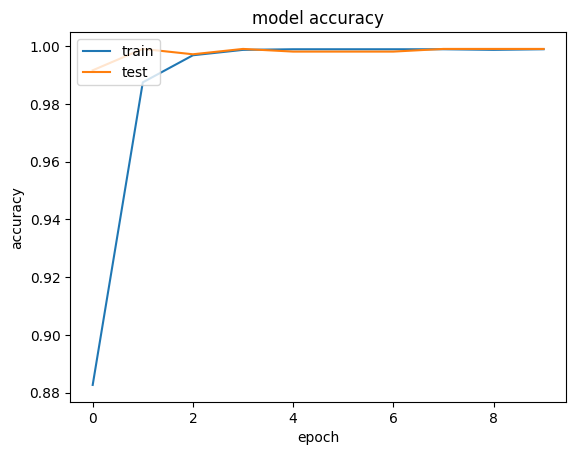

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model.save('model')

In [ ]:
predicted_y = model.predict(X_test)
predicted_y = np.vectorize(lambda x: labels[x])(np.argmax(predicted_y, axis=1))

34/34 [==============================] - 0s 1ms/step


In [ ]:
cm = confusion_matrix(y_test_original, predicted_y, labels=labels)
cm

array([[264,   1,   0,   0,   0],
       [  0, 285,   0,   0,   0],
       [  0,   0, 155,   0,   0],
       [  0,   0,   0, 205,   0],
       [  0,   0,   0,   0, 170]])

<Axes: >

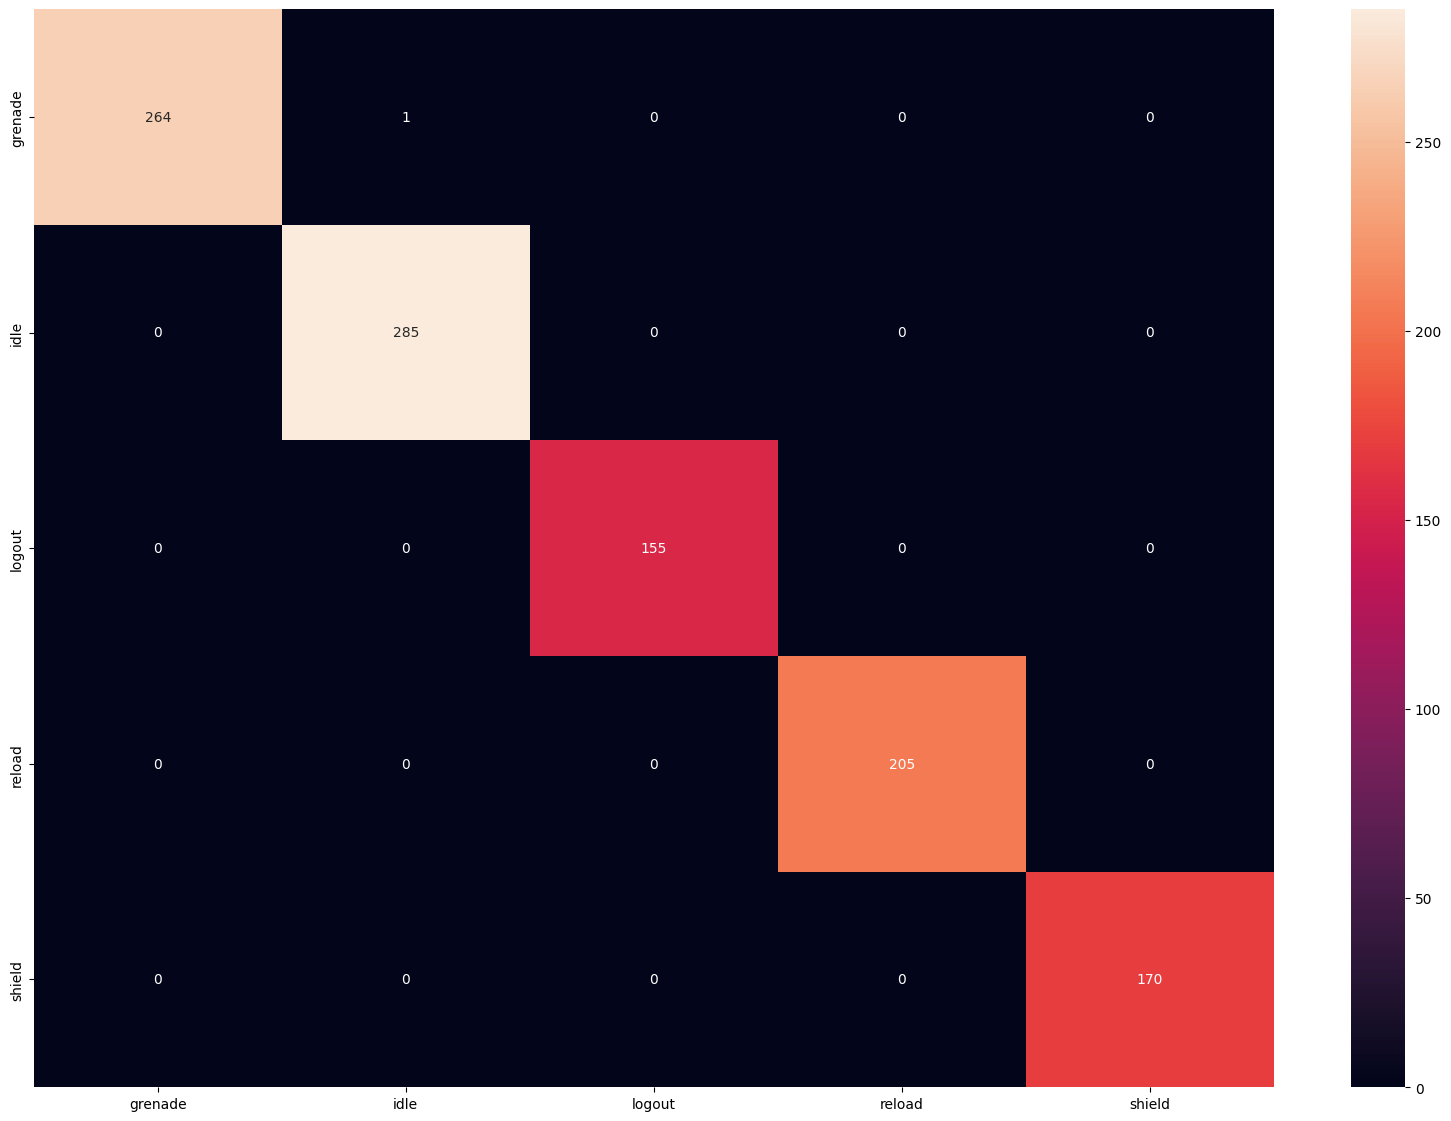

In [ ]:
df_cm = pd.DataFrame(cm, index = labels,
                  columns = labels)
plt.figure(figsize = (20,14))
sns.heatmap(df_cm, annot=True, fmt="d")

In [ ]:
print(classification_report(y_test_original, predicted_y, target_names=labels))

              precision    recall  f1-score   support

     grenade       1.00      1.00      1.00       265
        idle       1.00      1.00      1.00       285
      logout       1.00      1.00      1.00       155
      reload       1.00      1.00      1.00       205
      shield       1.00      1.00      1.00       170

    accuracy                           1.00      1080
   macro avg       1.00      1.00      1.00      1080
weighted avg       1.00      1.00      1.00      1080



In [ ]:
model = keras.models.load_model('model')

In [ ]:
first_layer_weights = list(model.layers[0].get_weights()[0])
first_layer_biases  = list(model.layers[0].get_weights()[1])
second_layer_weights = list(model.layers[1].get_weights()[0])
second_layer_biases  = list(model.layers[1].get_weights()[1])
third_layer_weights = list(model.layers[2].get_weights()[0])
third_layer_biases  = list(model.layers[2].get_weights()[1])

In [ ]:
for neuron in third_layer_weights:
  print('{', end=' ')
  for i, weight in enumerate(neuron):
    if i == len(neuron)-1:
      print(str(weight) + '},')
    else:
      print(weight, end=',')

{ 0.13625877,-0.17775086,-0.010230946,0.17172623,-0.095025264},
{ -0.32445255,0.053635646,-0.3189416,0.042747088,0.42965007},
{ -0.19431865,-0.4345313,-0.008507198,0.30592015,0.08341559},
{ 0.41422802,0.13843675,-0.3186866,-0.5028105,0.10364584},
{ -0.30250058,0.12480628,0.21205787,0.4512148,-0.33176225},
{ 0.49678314,0.042613313,-0.26254532,0.21075559,-0.053429887},
{ -0.5002568,0.18293196,-0.5627343,0.20820978,0.23100407},
{ -0.0043981955,-0.28684604,0.05800838,0.13180125,0.31835383},
{ -0.30599323,-0.045039516,0.27220613,-0.46032694,-0.2548918},
{ 0.23337202,0.2993883,-0.40017757,-0.35098422,0.070243694},
{ -0.0910276,-0.46316087,0.5004726,-0.3728288,0.08642776},
{ 0.33215126,-0.1421686,-0.41779727,0.37545562,-0.5208592},
{ 0.078813635,-0.41253582,-0.3991243,0.34651121,0.42916647},
{ -0.46699834,0.272947,-0.14973456,-0.52532345,0.36784348},
{ 0.0786907,0.38915893,-0.42066234,0.16991581,-0.44026878},
{ -0.16465934,0.23589829,0.07952394,-0.10210463,-0.33317196},
{ 0.28918672,-0.275198

In [ ]:
for bias in third_layer_biases:
  print(str(bias), end=',')

-0.051648594,0.048049092,-0.013791602,0.0076460103,-0.017936703,

In [ ]:
for elem in list(X_test.iloc[0]):
  print(elem, end=',')

1.3793761718489885,0.7582969962855348,0.8170703737956808,1.743818119615026,-0.22185226801902871,0.8850877726232147,1.6668797372947768,1.2355308217294956,0.9702793563303809,0.9760944067106975,-0.04267433357238791,0.9427450743417405,1.4813791675823877,0.7634815861064849,1.206118459173833,0.9511230712207693,0.610796519101558,0.9694328266575204,0.9895699795032008,0.3380678888579814,0.9561602531644781,1.3524452601957255,0.19732309194741668,1.1749500784262612,0.09675005795750112,0.26847107386214053,0.0038660545477327275,1.41788428038754,0.5126379882409887,1.569097292017665,-0.7041927453303621,1.0578829828053657,-0.9892167091310239,1.2664344937553809,0.5388509803569266,-1.665566216592405,-0.2546295498202073,1.3535634688936644,-1.332522767823267,0.08472081262324742,-1.307657713885864,-0.3584405203787161,-0.05788249343334612,1.205291177480441,-1.594292844513821,-1.0630524707505233,-0.9311720464529378,0.20178717652194839,-0.19520847258328075,0.7032583241359073,-1.062817420102631,-2.0297497710733

In [ ]:
predicted_y = model.predict(X_test)
predicted_y

34/34 [==============================] - 0s 890us/step


array([[9.9997288e-01, 8.2076895e-06, 1.6399972e-05, 1.9226311e-06,
        4.8046940e-07],
       [9.9999648e-01, 1.0393547e-06, 1.8720807e-06, 3.2292084e-07,
        1.7580844e-07],
       [9.9998635e-01, 3.8712761e-07, 1.2426748e-05, 5.2052104e-07,
        3.9335151e-07],
       ...,
       [5.2089163e-06, 1.9986208e-08, 1.8600914e-10, 6.3569495e-08,
        9.9999470e-01],
       [5.2186437e-07, 3.3940310e-08, 2.0662734e-09, 1.6848944e-08,
        9.9999934e-01],
       [4.5231222e-06, 1.0959278e-07, 1.2026270e-07, 1.9838936e-07,
        9.9999493e-01]], dtype=float32)